In [1]:
import ML_Coupling.mo_descriptor as md
import ML_Coupling.nn_frame as nn
import numpy as np
import subprocess
import copy
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2023-04-03 17:35:08.212459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 17:35:08.212506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [ ]:
'''
1. load mo_pair descriptor
'''
homo_pairs = np.load('./data/homo_homo_pair.npy')
lumo_pairs = np.load('./data/lumo_lumo_pair.npy')
homo_rot_pairs = np.load('./data/homo_pair_rot.npy')
lumo_rot_pairs = np.load('./data/lumo_pair_rot.npy')

In [14]:
'''
2. read coupling
'''
raw_data = np.loadtxt('./data/results.csv', delimiter=',',comments='#')
raw_data_rot = np.loadtxt('./data/results_rot.csv', delimiter=',',comments='#')
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])
c_homo_rot = abs(raw_data_rot[:,3])
c_lumo_rot = abs(raw_data_rot[:,4])

In [ ]:
'''
4. remove zero values for full data set
'''
ihzero = []
for ii,i in np.ndenumerate(c_homo):
    if i<=0.00000000:
        ihzero.append(ii)
        c_homo[ii] = 1e-9
print('Number of points to be deleted for homo:  ',len(ihzero))
homo_pairs  = np.delete(homo_pairs , ihzero, 0)
c_homo= np.delete(c_homo , ihzero, 0)

ilzero = []
for ii,i in np.ndenumerate(c_lumo):
    if i<=0.00000000:
        ilzero.append(ii)
        c_lumo[ii] = 1e-9
print('Number of points to be deleted for lumo:  ',len(ilzero))
lumo_pairs  = np.delete(lumo_pairs , ilzero, 0)
c_lumo = np.delete(c_lumo , ilzero, 0)

Number of points to be deleted for homo:   35011
Number of points to be deleted for lumo:   1140


In [16]:
'''
5. build training set
'''
n = 5
istart = n * 1681
iend = (n+1) * 1681
train_homo_pairs = homo_pairs[istart:iend]
train_lumo_pairs = lumo_pairs[istart:iend]

train_c_homo = -np.log(c_homo)[istart:iend]
train_c_lumo = -np.log(c_lumo)[istart:iend]

train_homo = copy.deepcopy(train_homo_pairs)
train_chomo = copy.deepcopy(train_c_homo)
print('Size of full training set for homo:   ',len(train_chomo))
index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)*0), replace=False)
train_homo_ = np.delete(train_homo,index,0)
train_chomo_ = np.delete(train_chomo,index,0)
print('Size of selected training set for homo:   ',len(train_homo_))

train_lumo = copy.deepcopy(train_lumo_pairs)
train_clumo = copy.deepcopy(train_c_lumo)
print('Size of full training set for lumo:   ',len(train_clumo))
index = np.random.choice(len(train_c_lumo), size=int(len(train_c_lumo)*0), replace=False)
train_lumo_ = np.delete(train_lumo,index,0)
train_clumo_ = np.delete(train_clumo,index,0)
print('Size of selected training set for lumo:   ',len(train_lumo_))

Size of full training set for homo:    1681
Size of selected training set for homo:    1681
Size of full training set for lumo:    1681
Size of selected training set for lumo:    1681


/tmp/ipykernel_1937/1331834186.py:10: RuntimeWarning: divide by zero encountered in log
  train_c_homo = -np.log(c_homo)[istart:iend]
/tmp/ipykernel_1937/1331834186.py:11: RuntimeWarning: divide by zero encountered in log
  train_c_lumo = -np.log(c_lumo)[istart:iend]


In [ ]:
'''
6. build testing set
'''
iall = np.arange(len(train_c_homo))
idiff = np.setdiff1d(iall,index)
test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

iall = np.arange(len(train_c_lumo))
idiff = np.setdiff1d(iall,index)
test_lumo = np.delete(copy.deepcopy(train_lumo_pairs),idiff,0)
test_clumo = np.delete(copy.deepcopy(train_clumo),idiff,0)

In [7]:
'''
7. load model 
''' 
imodel = 715
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./trained_model/nat_dimer_homo_total_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_homo_total_%d/model'%imodel}
NN_ho1 = nn.NN(setting_dict=setting)
pred_ho1 = np.exp(-NN_ho1.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),)))

imodel = 9098
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./trained_model/nat_dimer_homo_total_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_homo_total_%d/model'%imodel}
NN_ho2 = nn.NN(setting_dict=setting)
pred_ho2 = np.exp(-NN_ho2.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),)))

imodel = 67054
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./trained_model/nat_dimer_homo_total_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_homo_total_%d/model'%imodel}
NN_ho3 = nn.NN(setting_dict=setting)
pred_ho3 = np.exp(-NN_ho3.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),)))

imodel = 67767
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./trained_model/nat_dimer_homo_total_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_homo_total_%d/model'%imodel}
NN_ho4 = nn.NN(setting_dict=setting)
pred_ho4 = np.exp(-NN_ho4.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),)))


2023-03-17 13:37:03.700945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 13:37:03.701004: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 13:37:03.701046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Bai-Group): /proc/driver/nvidia/version does not exist
2023-03-17 13:37:03.702539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
imodel2 = 9104
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_lumo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./nat_dimer_lumo_total_%d'%len(train_lumo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_lumo_total_%d/model'%imodel2}
NN_lu = nn.NN(setting_dict=setting)
pred_lu = np.exp(-NN_lu.model(train_lumo_pairs, training=False).numpy().reshape((len(train_lumo_pairs),)))


In [12]:
error_ho1 = np.mean(np.multiply(abs(pred_ho1-np.exp(-train_c_homo)), np.power(np.exp(-train_c_homo),-1))*100)
print(error_ho1)
error_lu = np.mean(np.multiply(abs(pred_lu-train_c_lumo), np.power(train_c_lumo,-1))*100)

error_ho2 = np.mean(np.multiply(abs(pred_ho2-np.exp(-train_c_homo)), np.power(np.exp(-train_c_homo),-1))*100)
print(error_ho2)
error_lu = np.mean(np.multiply(abs(pred_lu-train_c_lumo), np.power(train_c_lumo,-1))*100)

error_ho3 = np.mean(np.multiply(abs(pred_ho3-np.exp(-train_c_homo)), np.power(np.exp(-train_c_homo),-1))*100)
print(error_ho3)
error_lu = np.mean(np.multiply(abs(pred_lu-train_c_lumo), np.power(train_c_lumo,-1))*100)

error_ho4 = np.mean(np.multiply(abs(pred_ho4-np.exp(-train_c_homo)), np.power(np.exp(-train_c_homo),-1))*100)
print(error_ho4)
error_lu = np.mean(np.multiply(abs(pred_lu-train_c_lumo), np.power(train_c_lumo,-1))*100)

32.36276668610072
5.059794229933534
2.1662347003302322
1.699314022464283


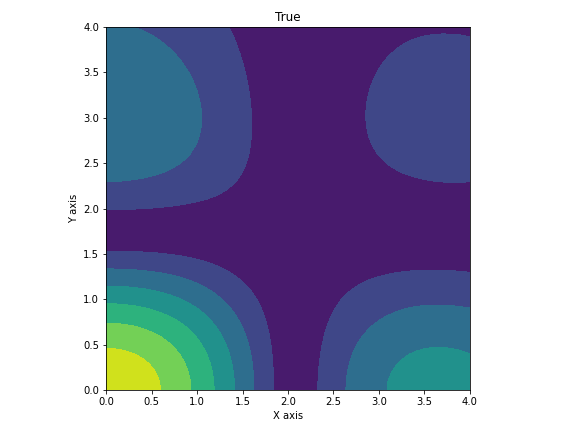

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
Z = np.exp(-train_c_homo).reshape((41,41))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.contourf(x,y, Z.T)
ax1.set_title('True')
ax1.set_aspect('equal')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
plt.tight_layout()
# plt.savefig('2d_true.png')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


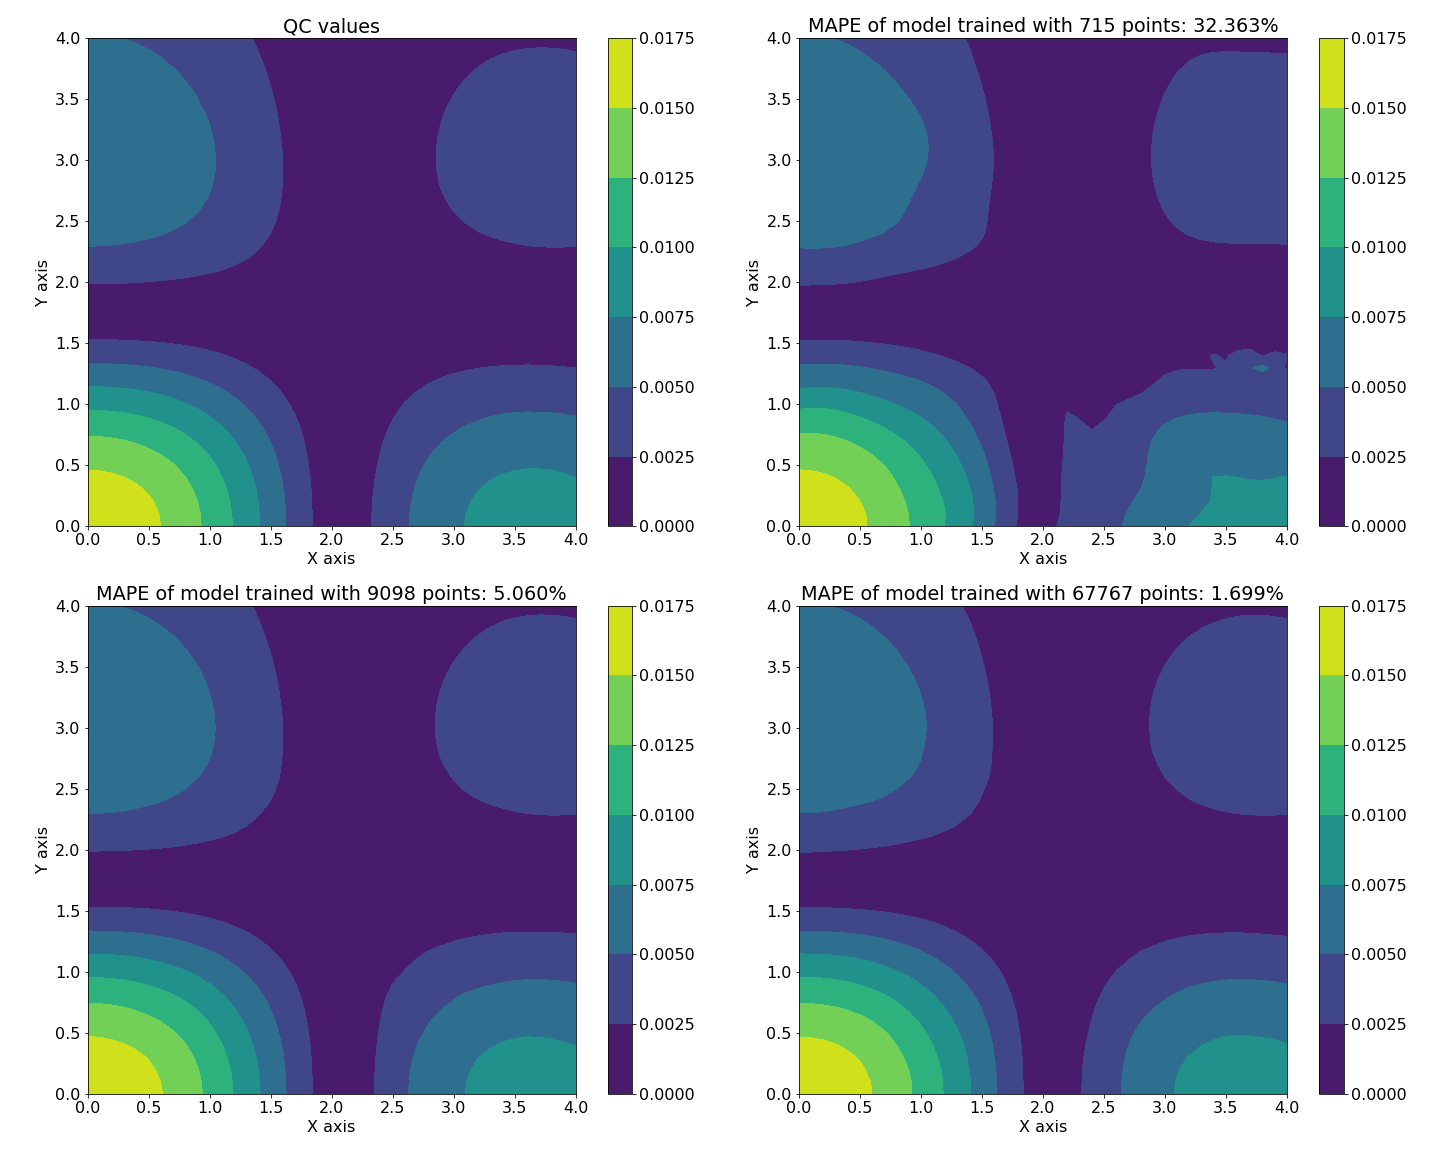

In [81]:
Z1 = pred_ho1.reshape((41,41))
Z2 = pred_ho2.reshape((41,41))
Z3 = pred_ho3.reshape((41,41))
Z4 = pred_ho4.reshape((41,41))
Z_ = [Z,Z1,Z2,Z3,Z4]

fig2, ax2 = plt.subplots(2,2,figsize=(20,16))
plt.rcParams.update({'font.size':16})
plt.rc('font',family='Times New Roman')
a1 = ax2[0,0].contourf(x,y, Z.T)
ax2[0,0].set_aspect('equal')
ax2[0,0].set_title('QC values')
ax2[0,0].set_xlabel('X axis')
ax2[0,0].set_ylabel('Y axis')

a2 = ax2[0,1].contourf(x,y, Z1.T)
ax2[0,1].set_aspect('equal')
ax2[0,1].set_title('MAPE of model trained with 715 points: %5.3f%%'%error_ho1)
ax2[0,1].set_xlabel('X axis')
ax2[0,1].set_ylabel('Y axis')

a2a3= ax2[1,0].contourf(x,y, Z2.T)
ax2[1,0].set_aspect('equal')
ax2[1,0].set_title('MAPE of model trained with 9098 points: %5.3f%%'%error_ho2)
ax2[1,0].set_xlabel('X axis')
ax2[1,0].set_ylabel('Y axis')

a4 = ax2[1,1].contourf(x,y, Z4.T)
ax2[1,1].set_aspect('equal')
ax2[1,1].set_title('MAPE of model trained with 67767 points: %5.3f%%'%error_ho4)
ax2[1,1].set_xlabel('X axis')
ax2[1,1].set_ylabel('Y axis')


fig2.colorbar(a1,ax=ax2[0,0])
fig2.colorbar(a2,ax=ax2[0,1])
fig2.colorbar(a3,ax=ax2[1,0])
fig2.colorbar(a4,ax=ax2[1,1])
# fig2.colorbar(a4,ax=ax2[:,1])
plt.tight_layout()

plt.savefig('2d_pred_model.png', transparent=False)

In [57]:
import ML_Coupling.tools as tool
import numpy as np

read_xyz = tool.read_xyz

def check_close_mol(xyz1, xyz2):
    '''
    check if the two given molecule overlap/bonding with each other.
    '''
    vdw_r ={'ch':1, 'cc':1, 'hh':1, 'co':1, 'oh':1, 'cn':1, 'nh':1}
    n_atom1, atom_sym1, mol1 = read_xyz(xyz1)
    n_atom2, atom_sym2, mol2 = read_xyz(xyz2)
    dist = []
    for i in range(0, 3):            # make q_i - q_j along x, y, z axis where q is generalized coordinate
        dist_ = np.power(np.log(np.outer(np.exp(mol1[:, i]), np.exp(-mol2[:, i]))),2)
        dist.append(dist_)
    ecu_dist = np.sqrt(np.add(np.add(dist[0], dist[1]), dist[2]))
    

    bonds = []
    for ii ,i in enumerate(atom_sym1):
        for jj, j in enumerate(atom_sym2):
            bonds.append(i+j)
            
    for ii,i in enumerate(bonds):
        if i.lower() == 'cc':
            bonds[ii] = 'cc'
        elif i.lower() == 'hh':
            bonds[ii] = 'hh'
        elif i.lower() == 'ch' or i.lower() =='hc':
            bonds[ii] = 'ch'
        elif i.lower() == 'co' or i.lower() == 'oc':
            bonds[ii] = 'co'
        elif i.lower() == 'oh' or i.lower() == 'ho':
            bonds[ii] = 'oh'
        elif i.lower() == 'cn' or i.lower() == 'nc':
            bonds[ii] = 'cn'
        elif i.lower() == 'nh' or i.lower() == 'hn':
            bonds[ii] = 'nh'

    bonds = np.array(bonds).reshape(ecu_dist.shape)
    overlap_bond = False

    for ii, i in np.ndenumerate(ecu_dist):
        bond_type = bonds[ii]
        if i < vdw_r[bond_type]:
            overlap_bond = True
            print(ii,i)
            break
        
    return overlap_bond

path1='./test/nat1.xyz'
path2='./test/nat2.xyz'

In [58]:
a=check_close_mol(path1,path2)
print(a)

4.278876667298557
True
